In [40]:
import numpy as np
import scipy.misc
import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

labels = ['gyoku', 'ou', 'kin', 'gin', 'kei', 'kyo', 'kaku', 'hi', 'fu', 'narigin', 'narikei', 'narikyo', 'uma', 'ryu', 'to']

num_classes = len(labels) * 2
# input image dimensions
img_rows, img_cols = 48, 48

x_train = np.empty((0, img_rows, img_cols))
y_train = np.empty((0))
for i, label in enumerate(labels):
    x = np.load("data/%s.npz" % label)['arr_0'].astype(np.float32)
    x_p = np.rot90(x, 2)
    y = np.full((len(x)), i)
    y_p = np.full((len(x)), len(labels) + i)
    x_train = np.r_[x_train, x, x_p]
    y_train = np.r_[y_train, y, y_p]

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.25)
datagen.fit(x_train)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=16), steps_per_epoch=x_train.shape[0],
                    epochs=30, verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (588, 48, 48, 1)
588 train samples
66 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 18, 18, 64)        36928     
_________________________________________________________________
max_poolin

In [70]:
pred_res = model.predict(x_test)

In [79]:
res = np.array([np.argmax(r) for r in pred_res])
ans = np.array([np.where(y == 1)[0][0] for y in y_test])
print(res)
print(ans)
errors = np.where(res != ans)[0]
print(errors)

[ 6  4 12  0  8 23 17 21 10 18  7 14  7  6  0 20  5 22 20  4 24 11 28 14 28
 27  6  1  6 29  1 10  6 29 17 17  7  3 22  0 25  2 24  2  3 11  3  7  0 16
 28  9  1 18  8 19  5 16 14 17 23  9 29 24  1 19]
[ 6  4 12  0  8 23 17 21  5 18  7 14  7  6  0 20  5 22 20  4 25 11 28 14 28
 28  6  1  6 29  0 10  6 29 17 17  7  3 22  0 25  2 24  2  3 11  3  7  0 16
 28  9  1 18  8 19  5 16 14 17 23  9 29 25  0 19]
[ 8 20 25 30 63 64]


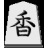

narikei


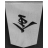

p
narigin


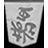

p
uma


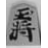

ou


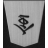

p
narigin


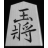

ou


In [83]:
from io import BytesIO
from IPython import display
from PIL import Image

def display_image(arr):
    b = BytesIO()
    Image.fromarray(np.uint8(arr)).save(b, format='png')
    data = b.getvalue()
    display.display(display.Image(data=data, format='png', embed=True))

for e in errors:
    display_image(np.uint8(x_test[e] * 255)[:, :, 0])
    if len(labels) > res[e]:
        print(labels[res[e]])
    else:
        print("p")
        print(labels[res[e] - len(labels)])